## Import libraries

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    ExpSineSquared,
    DotProduct,
    WhiteKernel
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score

## Read in data

In [340]:
# Read data
train = pd.read_csv('./processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2022-01-24 00:00:00,22.0,101.13,3107,347.43,483.27,2.26,21,0,2022-01-24 00:00:00,0,0,1
2022-01-24 01:00:00,19.0,49.71,2027,188.00,295.90,2.06,18,0,2022-01-24 01:00:00,0,1,2
2022-01-24 02:00:00,17.0,35.84,1562,139.00,198.57,0.00,14,0,2022-01-24 02:00:00,0,2,3
2022-01-24 03:00:00,6.0,19.49,989,73.50,105.86,1.25,6,0,2022-01-24 03:00:00,0,3,4
2022-01-24 04:00:00,18.0,27.95,1730,104.50,174.88,1.90,14,0,2022-01-24 04:00:00,0,4,5


In [341]:
# Read data
test = pd.read_csv('./processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekday,hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,
2024-01-22 00:00:00,30.0,47.67,3190,259.20,395.36,0.00,24,0,2024-01-22 00:00:00,0,0,1
2024-01-22 01:00:00,24.0,55.16,4013,298.80,465.53,2.08,24,0,2024-01-22 01:00:00,0,1,2
2024-01-22 02:00:00,11.0,19.38,949,93.10,137.38,0.00,9,0,2024-01-22 02:00:00,0,2,3
2024-01-22 03:00:00,10.0,21.98,1406,125.90,197.42,0.00,10,0,2024-01-22 03:00:00,0,3,4
2024-01-22 04:00:00,6.0,36.57,1195,160.31,234.16,3.00,7,0,2024-01-22 04:00:00,0,4,5


In [342]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5424 entries, 2022-01-24 00:00:00 to 2023-05-15 23:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  5424 non-null   float64
 1   trip_distance    5424 non-null   float64
 2   DOLocationID     5424 non-null   int64  
 3   fare_amount      5424 non-null   float64
 4   total_amount     5424 non-null   float64
 5   tip_amount       5424 non-null   float64
 6   pickup_count     5424 non-null   int64  
 7   is_holiday       5424 non-null   int64  
 8   pickup_time      5424 non-null   object 
 9   weekday          5424 non-null   int64  
 10  hour             5424 non-null   int32  
 11  time_index       5424 non-null   int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 529.7+ KB


In [343]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2712 entries, 2024-01-22 00:00:00 to 2024-05-13 23:00:00
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  2712 non-null   float64
 1   trip_distance    2712 non-null   float64
 2   DOLocationID     2712 non-null   int64  
 3   fare_amount      2712 non-null   float64
 4   total_amount     2712 non-null   float64
 5   tip_amount       2712 non-null   float64
 6   pickup_count     2712 non-null   int64  
 7   is_holiday       2712 non-null   int64  
 8   pickup_time      2712 non-null   object 
 9   weekday          2712 non-null   int64  
 10  hour             2712 non-null   int32  
 11  time_index       2712 non-null   int64  
dtypes: float64(5), int32(1), int64(5), object(1)
memory usage: 264.8+ KB


In [344]:
## SHRINK SIZES IF NECESSARY
train = train[:1000]
test = test[:1000]

## EDA

<Axes: >

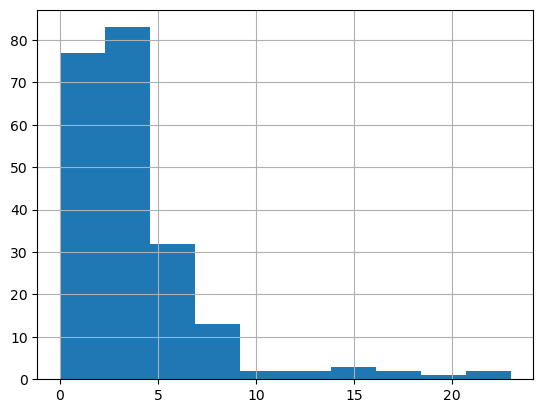

In [345]:
under_50 = train[train['pickup_count'] < 50]['hour']
under_50.hist() # When under 50 happens, per hour

In [346]:
train.groupby('hour')['pickup_count'].mean()

hour
0      67.952381
1      38.857143
2      28.285714
3      16.738095
4      15.761905
5      41.547619
6     154.666667
7     189.571429
8     171.357143
9     170.690476
10    173.404762
11    161.000000
12    179.047619
13    162.333333
14    172.857143
15    184.904762
16    162.902439
17    218.390244
18    224.024390
19    217.341463
20    169.024390
21    154.390244
22    143.292683
23    114.365854
Name: pickup_count, dtype: float64

<Axes: >

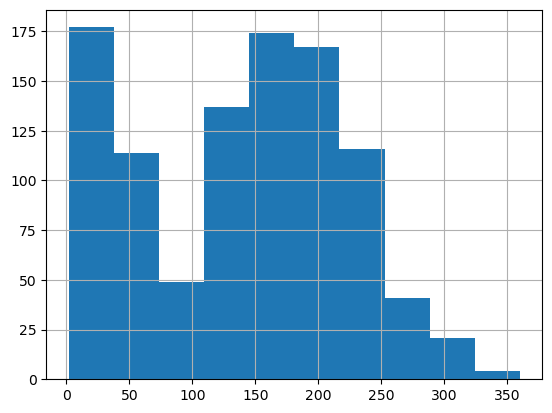

In [347]:
train['pickup_count'].hist()

<Axes: >

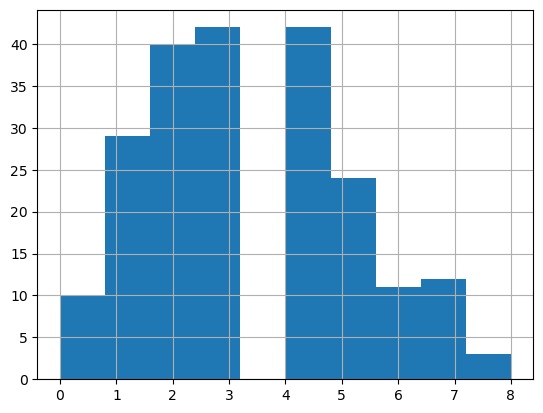

In [348]:
under_50_test = test[test['pickup_count'] < 50]['hour']
under_50_test.hist()

In [349]:
test.groupby('hour')['pickup_count'].mean()

hour
0      89.000000
1      42.142857
2      23.119048
3      13.619048
4      11.785714
5      43.976190
6      97.523810
7     143.261905
8     185.595238
9     199.428571
10    194.500000
11    190.928571
12    198.571429
13    187.904762
14    190.047619
15    186.809524
16    177.073171
17    207.243902
18    224.121951
19    193.243902
20    171.829268
21    207.121951
22    165.585366
23    137.439024
Name: pickup_count, dtype: float64

<Axes: >

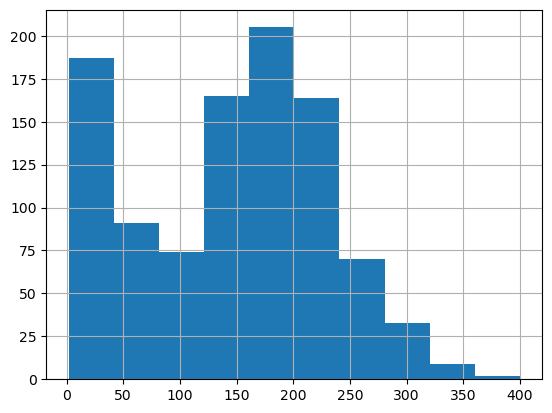

In [350]:
test['pickup_count'].hist()

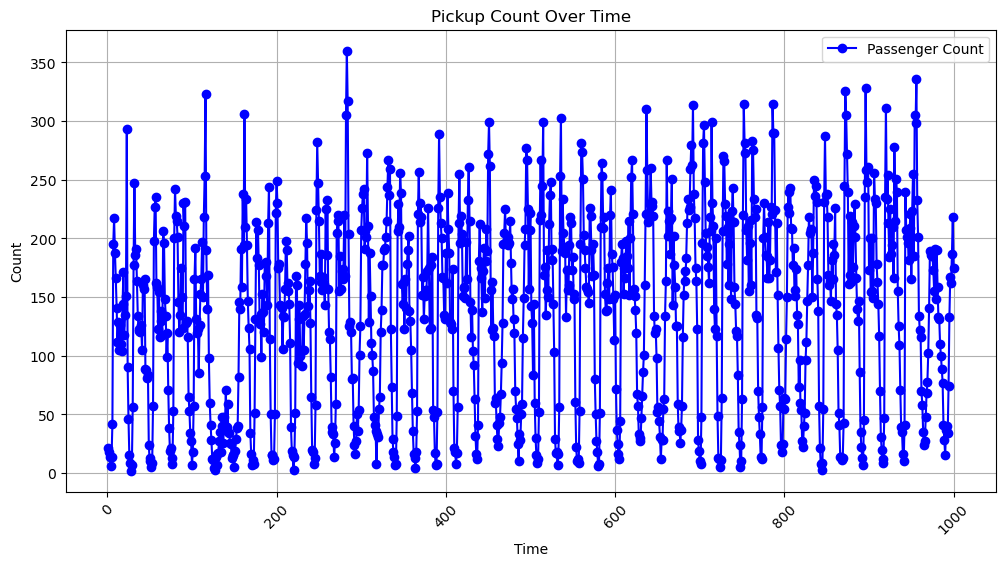

In [351]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Passenger Count', color='blue')
plt.title('Pickup Count Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

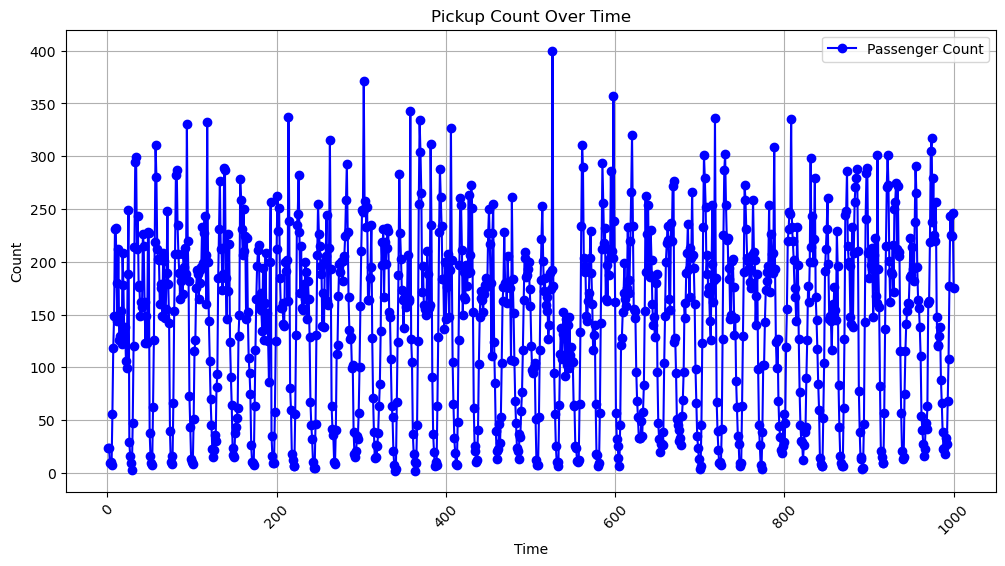

In [352]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Passenger Count', color='blue')
plt.title('Pickup Count Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Model Fitting

In [353]:
# Features (X) - Including the new feature
X_train = train[['hour', 'weekday']].values
X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour', 'weekday']].values
#X_test = test[['hour', 'weekday']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].values - mean_func
y_test = test['pickup_count'].values - mean_func

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [354]:
X_train

array([[0.        , 0.        ],
       [0.04347826, 0.        ],
       [0.08695652, 0.        ],
       ...,
       [0.56521739, 1.        ],
       [0.60869565, 1.        ],
       [0.65217391, 1.        ]])

In [355]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 2), (1000,), (1000, 2), (1000,))

In [356]:
# Define the GP kernel
# - RBF for smooth trends
# - ExpSineSquared for periodicity
kernel = (
   C(10.0, (1e-3, 1e3))  # Constant term to scale the entire kernel
   * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))  # Squared exponential

    + C(50.0, (1e-3, 1e3))  # Constant term for cosine scaling
    * ExpSineSquared(length_scale=1.0, periodicity=24, periodicity_bounds=(1e-2, 1e2), length_scale_bounds=(1e-2, 1e2))  # Cosine
## These two above work

    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-05, 100000.0))
)

# Instantiate and fit the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, alpha=1e-5)
gp.fit(X_train, y_train)
print("Fit Complete")
print("Learned Kernel:", gp.kernel_)

# Make predictions (add mean back)
y_pred, sigma = gp.predict(X_test, return_std=True)

Fit Complete
Learned Kernel: 31.6**2 * RBF(length_scale=0.119) + 19.7**2 * ExpSineSquared(length_scale=0.01, periodicity=0.0101) + WhiteKernel(noise_level=1.26e+03)


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Root Mean Squared Error: 45.148
R^2 Score: 0.715


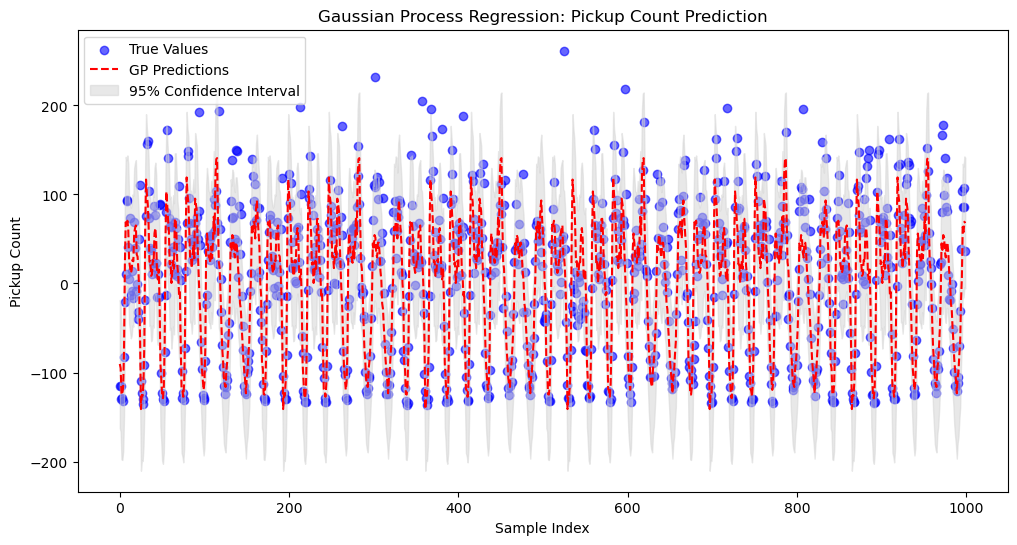

In [357]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred)), y_pred, label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred)),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()

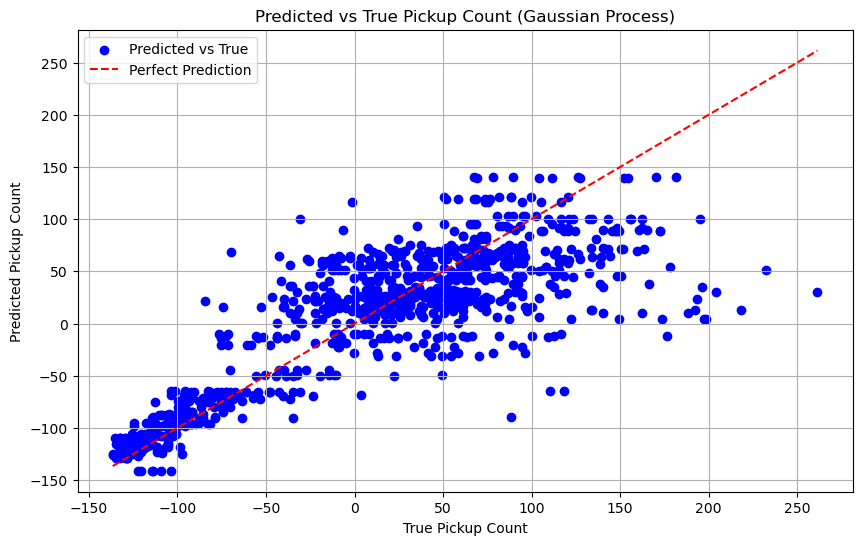

In [358]:
# Prediction vs True Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Pickup Count')
plt.ylabel('Predicted Pickup Count')
plt.title('Predicted vs True Pickup Count (Gaussian Process)')
plt.legend()
plt.grid(True)
plt.show()

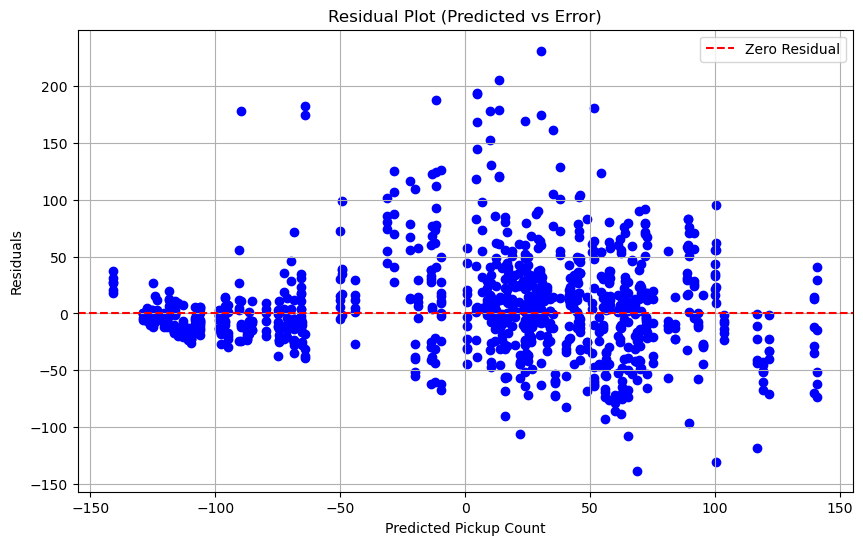

In [359]:
# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


In [360]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# R²
r2 = r2_score(y_test, y_pred)
print("R²:", r2)


RMSE: 45.14836289580518
R²: 0.7147103758869668


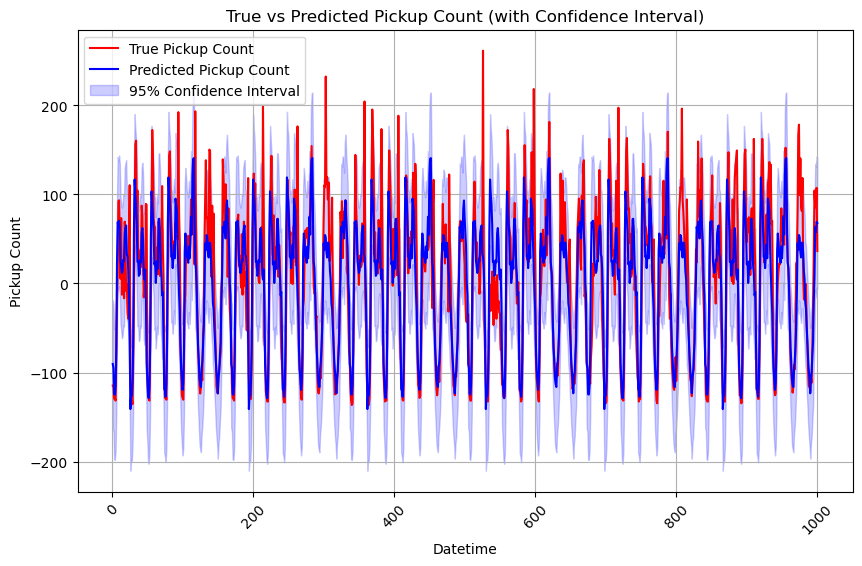

In [361]:
plt.figure(figsize=(10, 6))
plt.plot(test['time_index'], y_test, label='True Pickup Count', color='red')
plt.plot(test['time_index'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(test['time_index'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('True vs Predicted Pickup Count (with Confidence Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()